# TP7: MoE and LoRA


# Naive Expert Selection

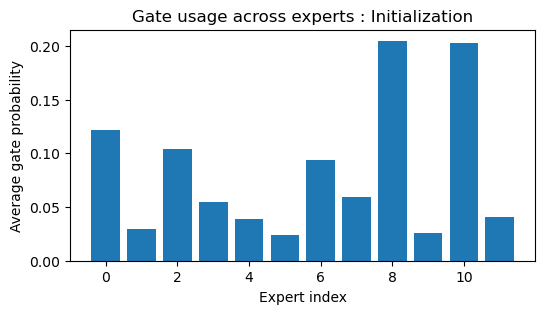

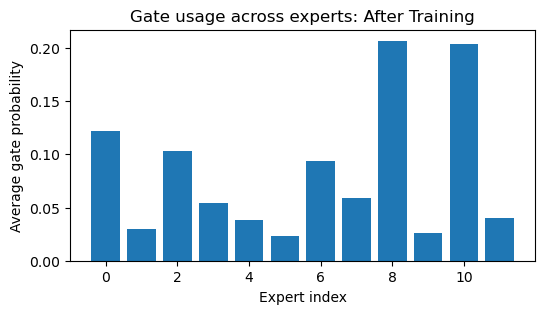

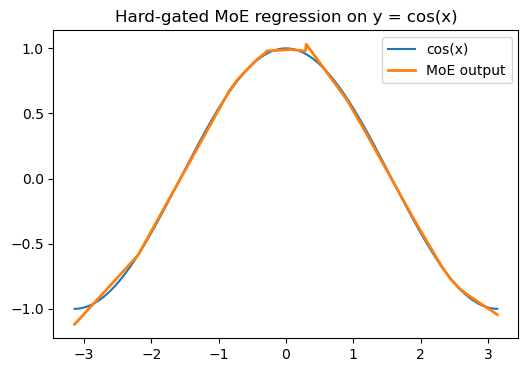

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt


# Hard Mixture of Experts Layer
class HardMoE(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_experts=30, k=1):
        super().__init__()
        self.num_experts = num_experts
        self.k = k

        self.gate = nn.Linear(input_dim, num_experts)

        self.experts = nn.ModuleList(
            [
                nn.Sequential(
                    nn.Linear(input_dim, hidden_dim),
                    nn.ReLU(),
                    nn.Linear(hidden_dim, 1),
                )
                for _ in range(num_experts)
            ]
        )

    def forward(self, x):
        logits = self.gate(x)  # B, E
        gates = F.softmax(logits, dim=-1)  # B, E

        # grab top-k experts
        topk_vals, topk_idx = torch.topk(gates, self.k, dim=-1)

        # normalize the top-k weights to sum to 1
        topk_weights = topk_vals / (topk_vals.sum(dim=-1, keepdim=True) + 1e-9)  #

        # compute expert outputs and combine them
        out = torch.zeros(x.size(0), 1, device=x.device)
        expert_outputs = torch.zeros(x.size(0), self.num_experts, device=x.device)
        for i in range(self.k):
            # grab which expert to use and its weight
            expert_idx = topk_idx[:, i]
            weight = topk_weights[:, i].unsqueeze(1)

            # we do the masking because we need to batch
            # loop through experts
            for e in range(self.num_experts):
                # check if this expert is selected
                mask = expert_idx == e
                # compute output only for selected inputs
                if mask.any():
                    expert = self.experts[e]
                    y_e = expert(x[mask])
                    out[mask] += weight[mask] * y_e
                    expert_outputs[mask, e] = y_e.squeeze(1)

        return out, gates, expert_outputs


# Dataset: y = cos(x)
N = 512
x = torch.linspace(-3.14, 3.14, N).unsqueeze(1)
y_true = torch.cos(x)

# Model, loss, optimizer
moe = HardMoE(input_dim=1, hidden_dim=32, num_experts=12, k=1)
opt = torch.optim.Adam(moe.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

y_pred, gates, experts_out = moe(x)
with torch.no_grad():
    gate_usage = gates.mean(0)
plt.figure(figsize=(6, 3))
plt.bar(range(moe.num_experts), gate_usage.numpy())
plt.xlabel("Expert index")
plt.ylabel("Average gate probability")
plt.title("Gate usage across experts : Initialization")
plt.show()

# Training loop
for step in range(2000):
    y_pred, gates, experts_out = moe(x)
    loss = loss_fn(y_pred, y_true)
    opt.zero_grad()
    loss.backward()
    opt.step()

y_pred, gates, experts_out = moe(x)
with torch.no_grad():
    gate_usage = gates.mean(0)
plt.figure(figsize=(6, 3))
plt.bar(range(moe.num_experts), gate_usage.numpy())
plt.xlabel("Expert index")
plt.ylabel("Average gate probability")
plt.title("Gate usage across experts: After Training")
plt.show()

# Visualization
with torch.no_grad():
    y_pred, gates, _ = moe(x)

plt.figure(figsize=(6, 4))
plt.plot(x, y_true, label="cos(x)")
plt.plot(x, y_pred, label="MoE output", lw=2)
plt.legend()
plt.title("Hard-gated MoE regression on y = cos(x)")
plt.show()


# Visualize Expert Assignment

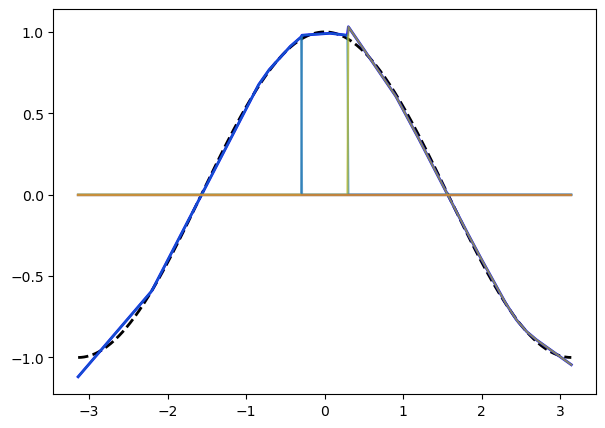

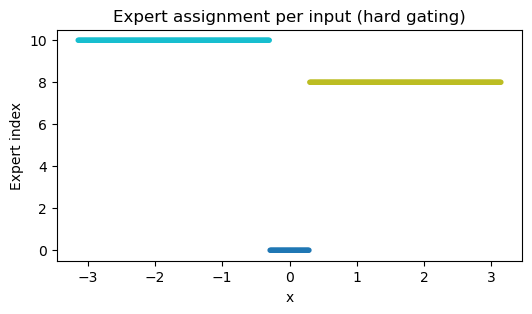

In [14]:
with torch.no_grad():
    y_pred, gates, expert_outputs = moe(x)

plt.figure(figsize=(7, 5))
plt.plot(x, y_true, "k--", label="cos(x)", lw=2)
plt.plot(x, y_pred, "b", label="MoE output", lw=2)

# Plot each expert’s raw output
for i in range(moe.num_experts):
    plt.plot(x, expert_outputs[:, i], label=f"Expert {i}", alpha=0.7)

# Visualize which expert was chosen for each x
with torch.no_grad():
    _, gates, _ = moe(x)
    top_expert = gates.argmax(dim=1)

plt.figure(figsize=(6, 3))
plt.scatter(x.squeeze(), top_expert, c=top_expert, cmap="tab10", s=8)
plt.title("Expert assignment per input (hard gating)")
plt.xlabel("x")
plt.ylabel("Expert index")
plt.show()

# Using the Gumbel-Softmax trick to select experts in a differentiable way

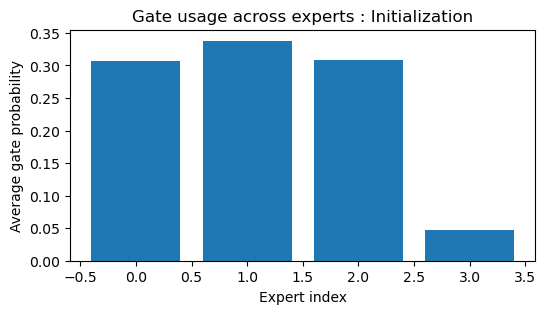

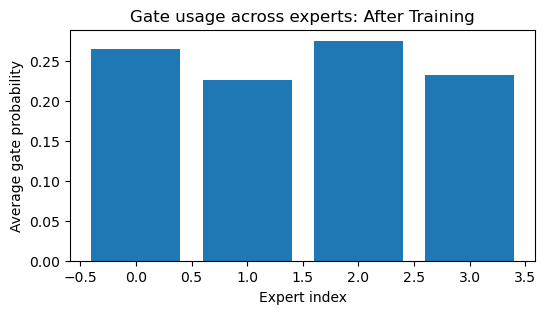

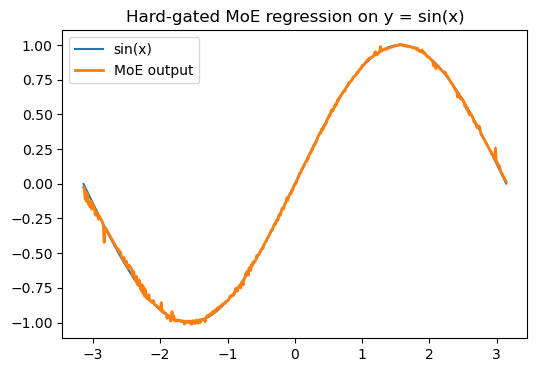

In [19]:
def gumbel_softmax(logits, tau=1.0):
    g = -torch.empty_like(logits).exponential_().log()  # Gumbel noise
    y = F.softmax((logits + g) / tau, dim=-1)

    # make one-hot in forward pass
    y_hard = torch.zeros_like(y)
    y_hard.scatter_(1, y.argmax(dim=-1, keepdim=True), 1.0)
    # Straight-through trick:
    # gradient flows through soft y
    # but forward is hard one-hot
    y = (y_hard - y).detach() + y
    return y


# Hard Mixture of Experts Layer
class HardMoE(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_experts=30, k=1):
        super().__init__()
        self.num_experts = num_experts
        self.k = k

        self.gate = nn.Linear(input_dim, num_experts)

        self.experts = nn.ModuleList(
            [
                nn.Sequential(
                    nn.Linear(input_dim, hidden_dim),
                    nn.ReLU(),
                    nn.Linear(hidden_dim, 1),
                )
                for _ in range(num_experts)
            ]
        )

    def forward(self, x):
        logits = self.gate(x)  # B, E

        # Get hard gate probabilities via Gumbel-Softmax
        gates = gumbel_softmax(logits)  # B, E

        # Compute all expert outputs
        expert_outputs = torch.stack(
            [expert(x) for expert in self.experts], dim=1
        )  # B, E, 1

        # Combine using gate probabilities
        out = torch.sum(gates.unsqueeze(-1) * expert_outputs, dim=1)  # [B, 1]

        # mean gate probability per expert
        mean_gate = gates.mean(dim=0)  # [E]

        # fraction of tokens assigned (hard routing)
        hard_assignments = gates.argmax(dim=-1)  # [B]

        # Loss: encourage mean_gate and load to match uniform use
        one_hot = F.one_hot(hard_assignments, self.num_experts).float()
        load = one_hot.mean(dim=0)  # [E]
        load_balance_loss = self.num_experts * torch.sum(mean_gate * load)

        return out, gates, expert_outputs.squeeze(-1), load_balance_loss


# Dataset: y = cos(x)
N = 512
x = torch.linspace(-3.14, 3.14, N).unsqueeze(1)
y_true = torch.sin(x)

# Model, loss, optimizer
moe = HardMoE(input_dim=1, hidden_dim=32, num_experts=4, k=2)
opt = torch.optim.Adam(moe.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()
beta = 0.1

y_pred, gates, experts_out, _ = moe(x)
with torch.no_grad():
    gate_usage = gates.mean(0)
plt.figure(figsize=(6, 3))
plt.bar(range(moe.num_experts), gate_usage.numpy())
plt.xlabel("Expert index")
plt.ylabel("Average gate probability")
plt.title("Gate usage across experts : Initialization")
plt.show()

# Training loop
for step in range(2000):
    y_pred, gates, experts_out, load_balance_loss = moe(x)
    loss = loss_fn(y_pred, y_true) + beta * load_balance_loss
    opt.zero_grad()
    loss.backward()
    opt.step()

y_pred, gates, experts_out, _ = moe(x)
with torch.no_grad():
    gate_usage = gates.mean(0)
plt.figure(figsize=(6, 3))
plt.bar(range(moe.num_experts), gate_usage.numpy())
plt.xlabel("Expert index")
plt.ylabel("Average gate probability")
plt.title("Gate usage across experts: After Training")
plt.show()

# Visualization
with torch.no_grad():
    y_pred, gates, _, _ = moe(x)

plt.figure(figsize=(6, 4))
plt.plot(x, y_true, label="sin(x)")
plt.plot(x, y_pred, label="MoE output", lw=2)
plt.legend()
plt.title("Hard-gated MoE regression on y = sin(x)")
plt.show()


# Visualization

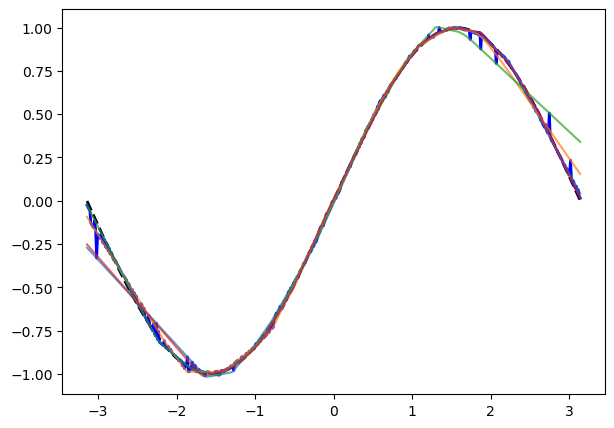

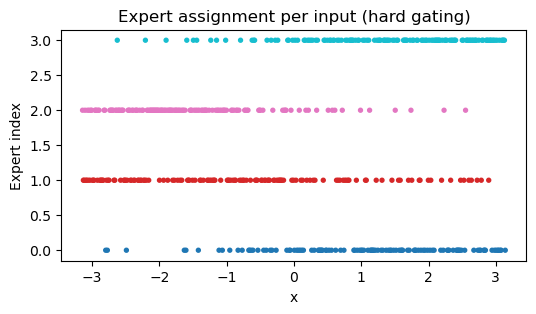

In [20]:
# Visualization
with torch.no_grad():
    y_pred, gates, expert_outputs, _ = moe(x)

plt.figure(figsize=(7, 5))
plt.plot(x, y_true, "k--", label="cos(x)", lw=2)
plt.plot(x, y_pred, "b", label="MoE output", lw=2)

# Plot each expert’s raw output
for i in range(moe.num_experts):
    plt.plot(x, expert_outputs[:, i], label=f"Expert {i}", alpha=0.7)

# Visualize which expert was chosen for each x
with torch.no_grad():
    _, gates, _, _ = moe(x)
    top_expert = gates.argmax(dim=1)

plt.figure(figsize=(6, 3))
plt.scatter(x.squeeze(), top_expert, c=top_expert, cmap="tab10", s=8)
plt.title("Expert assignment per input (hard gating)")
plt.xlabel("x")
plt.ylabel("Expert index")
plt.show()

# LoRA


This section introduces LoRA (Low-Rank Adaptation), a parameter-efficient fine-tuning technique for neural networks.
The code defines a LoRA-augmented MLP for MNIST, where most weights are frozen and only small low-rank adapters are trained.
 
The workflow includes pretraining a base MLP on a subset of digits, then fine-tuning the LoRA-augmented model on the full dataset,
demonstrating strong performance with a small fraction of trainable parameters.

In [30]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset


# Base Model
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(28 * 28, 32)
        self.fc2 = nn.Linear(32, 10)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        return self.fc2(F.relu(self.fc1(x)))


# LoRA Linear Layer
class LoRALinear(nn.Module):
    def __init__(self, in_features, out_features, r=2, alpha=1.0):
        super().__init__()
        self.r = r
        self.scale = alpha / r

        # frozen pretrained weights
        self.weight = nn.Parameter(torch.randn(out_features, in_features) * 0.02)
        self.weight.requires_grad = False

        # low-rank trainable adapters
        self.A = nn.Parameter(torch.randn(r, in_features) * 0.01)
        self.B = nn.Parameter(torch.randn(out_features, r) * 0.01)
        self.bias = nn.Parameter(torch.zeros(out_features))

    def forward(self, x):
        delta_w = (self.B @ self.A) * self.scale
        return F.linear(x, self.weight + delta_w, self.bias)


# LoRA-augmented MLP
# Forward is the same!
class LoRA_MLP(MLP):
    def __init__(self, pretrained_model, r=4):
        super().__init__()
        # Replace each layer with a LoRALinear, initialized from pretrained
        self.fc1 = LoRALinear(28 * 28, 32, r=r, alpha=r)
        self.fc2 = LoRALinear(32, 10, r=r, alpha=r)
        # self.fc3 = LoRALinear(128, 10, r=r, alpha=r)

        with torch.no_grad():
            self.fc1.weight.copy_(pretrained_model.fc1.weight)
            self.fc2.weight.copy_(pretrained_model.fc2.weight)
            # self.fc3.weight.copy_(pretrained_model.fc3.weight)


In [50]:
def train(model, loader, opt, epochs=1, device="cpu"):
    losses = []
    for epoch in range(epochs):
        total_loss, correct, total = 0.0, 0, 0
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            opt.zero_grad()
            out = model(x)
            loss = F.cross_entropy(out, y)
            loss.backward()
            opt.step()
            losses.append(loss.item())
            total_loss += loss.item() * x.size(0)
            correct += (out.argmax(dim=1) == y).sum().item()
            total += x.size(0)
        print(
            f"Epoch {epoch + 1}: loss={total_loss / total:.4f}, acc={correct / total * 100:.2f}%"
        )

    return losses


def evaluate(model, loader, device="cpu"):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            out = model(x)
            correct += (out.argmax(dim=1) == y).sum().item()
            total += x.size(0)
    return correct / total * 100

In [51]:
device = "cuda" if torch.cuda.is_available() else "cpu"

transform = transforms.Compose([transforms.ToTensor()])
train_data = datasets.MNIST(
    root="./data", train=True, download=True, transform=transform
)
test_data = datasets.MNIST(
    root="./data", train=False, download=True, transform=transform
)

# Split: pretrain on digits < 5, finetune on all digits
idx_pretrain = [i for i, t in enumerate(train_data.targets) if t < 5]
train_pretrain = Subset(train_data, idx_pretrain)

pre_loader = DataLoader(train_pretrain, batch_size=128, shuffle=True)
full_loader = DataLoader(train_data, batch_size=128, shuffle=True)
test_loader = DataLoader(test_data, batch_size=256, shuffle=False)


# Pretrain on subset of MNIST (digits < 5) + LoRA fine-tuning on full MNIST

In [61]:
base = MLP().to(device)
opt = torch.optim.Adam(base.parameters(), lr=1e-3)

print("Pretraining MLP on digits <5...")
train(base, pre_loader, opt, epochs=2, device=device)
acc_small = evaluate(base, test_loader, device)
print(f"Test accuracy on full data after pretraining on <5: {acc_small:.2f}%")

lora_model = LoRA_MLP(base, r=2).to(device)
opt_lora = torch.optim.Adam(
    filter(lambda p: p.requires_grad, lora_model.parameters()), lr=1e-3
)
print("\nFine-tuning with LoRA adapters on full MNIST...")
losses_w_pretrain = train(lora_model, full_loader, opt_lora, epochs=8, device=device)
acc_full = evaluate(lora_model, test_loader, device)
print(f"Test accuracy after LoRA fine-tuning: {acc_full:.2f}%")

# Parameter report
total = sum(p.numel() for p in lora_model.parameters())
trainable = sum(p.numel() for p in lora_model.parameters() if p.requires_grad)
print(f"\nTrainable params: {trainable}/{total} ({100 * trainable / total:.2f}%)")

Pretraining MLP on digits <5...
Epoch 1: loss=0.3856, acc=90.58%
Epoch 2: loss=0.1142, acc=96.74%
Test accuracy on full data after pretraining on <5: 50.11%

Fine-tuning with LoRA adapters on full MNIST...
Epoch 1: loss=1.7126, acc=54.78%
Epoch 2: loss=1.0318, acc=63.57%
Epoch 3: loss=0.8056, acc=74.10%
Epoch 4: loss=0.6101, acc=79.47%
Epoch 5: loss=0.5127, acc=83.22%
Epoch 6: loss=0.4732, acc=85.13%
Epoch 7: loss=0.4530, acc=86.08%
Epoch 8: loss=0.4385, acc=86.56%
Test accuracy after LoRA fine-tuning: 87.05%

Trainable params: 1758/27166 (6.47%)


# Ablation: LoRA from scratch

Check if pretraining is necessary for final performance.

In [62]:
base = MLP().to(device)
lora_model = LoRA_MLP(base, r=2).to(device)
opt_lora = torch.optim.Adam(
    filter(lambda p: p.requires_grad, lora_model.parameters()), lr=1e-3
)
print("\n Only tuning with LoRA on full MNIST...")
losses_without_pretrain = train(
    lora_model, full_loader, opt_lora, epochs=8, device=device
)
acc_full = evaluate(lora_model, test_loader, device)
print(f"Test accuracy: {acc_full:.2f}%")



 Only tuning with LoRA on full MNIST...
Epoch 1: loss=1.5701, acc=40.79%
Epoch 2: loss=1.0934, acc=60.31%
Epoch 3: loss=1.0224, acc=64.31%
Epoch 4: loss=0.9695, acc=66.94%
Epoch 5: loss=0.9331, acc=68.30%
Epoch 6: loss=0.9097, acc=69.21%
Epoch 7: loss=0.8946, acc=69.67%
Epoch 8: loss=0.8825, acc=70.09%
Test accuracy: 70.68%


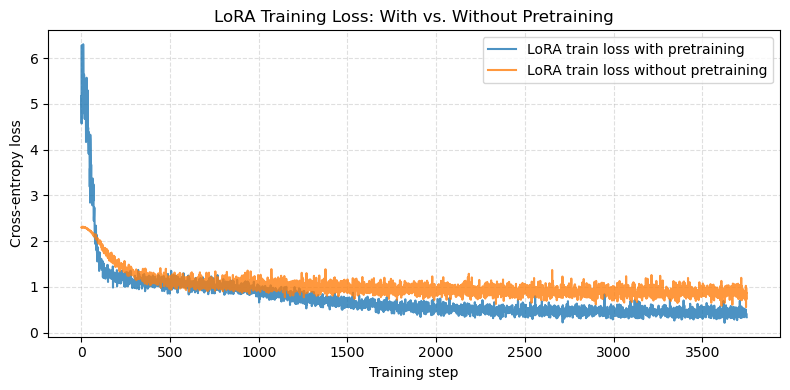

In [66]:
# With pretraining vs. without pretraining:
plt.figure(figsize=(8, 4))
plt.plot(losses_w_pretrain, label="LoRA train loss with pretraining", alpha=0.8)
plt.plot(
    losses_without_pretrain, label="LoRA train loss without pretraining", alpha=0.8
)
plt.xlabel("Training step")
plt.ylabel("Cross-entropy loss")
plt.title("LoRA Training Loss: With vs. Without Pretraining")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()

# Dataset scale

#### todo: check sources

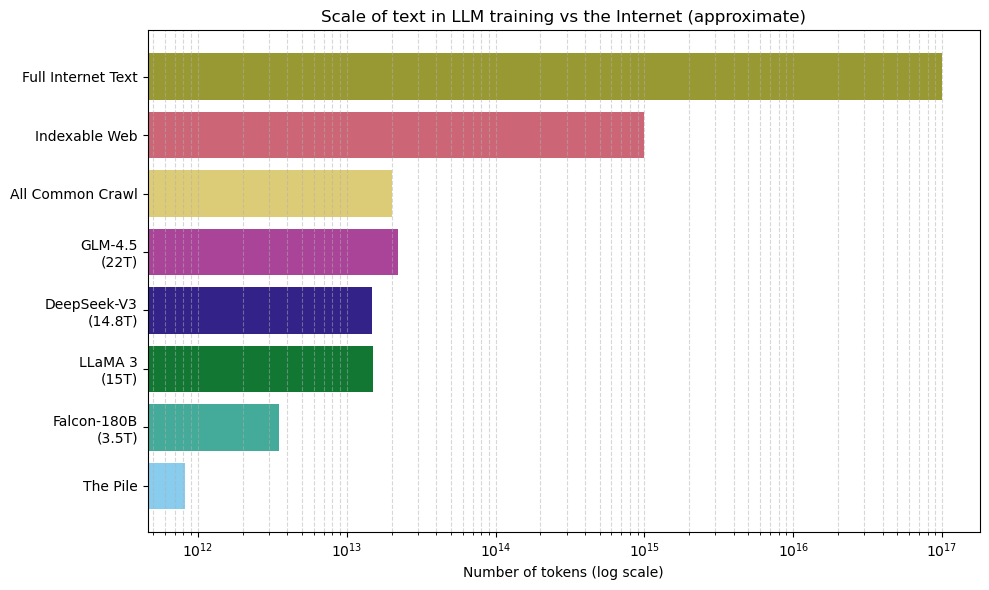

In [21]:
import matplotlib.pyplot as plt
import numpy as np

# Define sources and token scales (approximate, base-10 values)
sources = [
    "The Pile",
    "Falcon-180B\n(3.5T)",
    "LLaMA 3\n(15T)",
    "DeepSeek-V3\n(14.8T)",
    "GLM-4.5\n(22T)",
    "All Common Crawl",
    "Indexable Web",
    "Full Internet Text",
]

tokens = [
    8.25e11,  # The Pile
    3.5e12,  # Falcon
    1.5e13,  # Llama3
    1.48e13,  # DeepSeek
    2.2e13,  # GLM-4.5
    2e13,  # Common Crawl (approx total clean text)
    1e15,  # Indexable Web
    1e17,  # Full Internet text estimate
]

colors = [
    "#88CCEE",
    "#44AA99",
    "#117733",
    "#332288",
    "#AA4499",
    "#DDCC77",
    "#CC6677",
    "#999933",
]

plt.figure(figsize=(10, 6))
plt.barh(sources, tokens, color=colors)
plt.xscale("log")
plt.xlabel("Number of tokens (log scale)")
plt.title("Scale of text in LLM training vs the Internet (approximate)")
plt.grid(True, which="both", axis="x", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()